In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from shutil import copyfile, rmtree
from timeit import default_timer as timer

In [2]:
# Вспомогательная функция для доступа к файлам относительно корня директория с данными.
INPUT_ROOT = "../input/gtsrb-german-traffic-sign"
def from_input(path):
    return os.path.join(INPUT_ROOT, path)

In [3]:
# Загружаем таблицу с данными о данных.
train_info = pd.read_csv(from_input("Train.csv"))
train_info.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
# Посмотрим как выглядят наши данные.
train_info.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [5]:
# сколько примеров в каждом из классов
train_info.groupby('ClassId')['ClassId'].count()

ClassId
0      210
1     2220
2     2250
3     1410
4     1980
5     1860
6      420
7     1440
8     1410
9     1470
10    2010
11    1320
12    2100
13    2160
14     780
15     630
16     420
17    1110
18    1200
19     210
20     360
21     330
22     390
23     510
24     270
25    1500
26     600
27     240
28     540
29     270
30     450
31     780
32     240
33     689
34     420
35    1200
36     390
37     210
38    2070
39     300
40     360
41     240
42     240
Name: ClassId, dtype: int64

In [6]:
test_info =  pd.read_csv(from_input("Test.csv"))
test_info.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [7]:
test_info.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,50.507759,50.364450,5.998021,5.982423,44.864450,44.758116,15.551069
std,25.088483,23.698908,1.543954,1.427424,23.776102,22.494697,11.947123
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,29.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,57.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.000000,42.000000


In [8]:
# сколько примеров в каждом из классов
test_info.groupby('ClassId')['ClassId'].count()

ClassId
0      60
1     720
2     750
3     450
4     660
5     630
6     150
7     450
8     450
9     480
10    660
11    420
12    690
13    720
14    270
15    210
16    150
17    360
18    390
19     60
20     90
21     90
22    120
23    150
24     90
25    480
26    180
27     60
28    150
29     90
30    150
31    270
32     60
33    210
34    120
35    390
36    120
37     60
38    690
39     90
40     90
41     60
42     90
Name: ClassId, dtype: int64

In [9]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Показываем изображения в сетке 6х8.
nrows = 8
ncols = 6

pic_offset = 0 # Чтобы итерировать по изображениям каждый раз когда запустим код ниже.

In [10]:
def show_images(offset):
    fig = plt.gcf()
    fig.set_size_inches(ncols*3, nrows*3)

    for i in range(43):
        # subplot индексы начинаются с 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        subdir = os.path.join(from_input('train'), str(i))
        files = os.listdir(subdir)
        img_path = os.path.join(subdir, files[offset % len(files)])
        img = mpimg.imread(img_path)
        #print(img.shape)
        plt.imshow(img)

    plt.show()

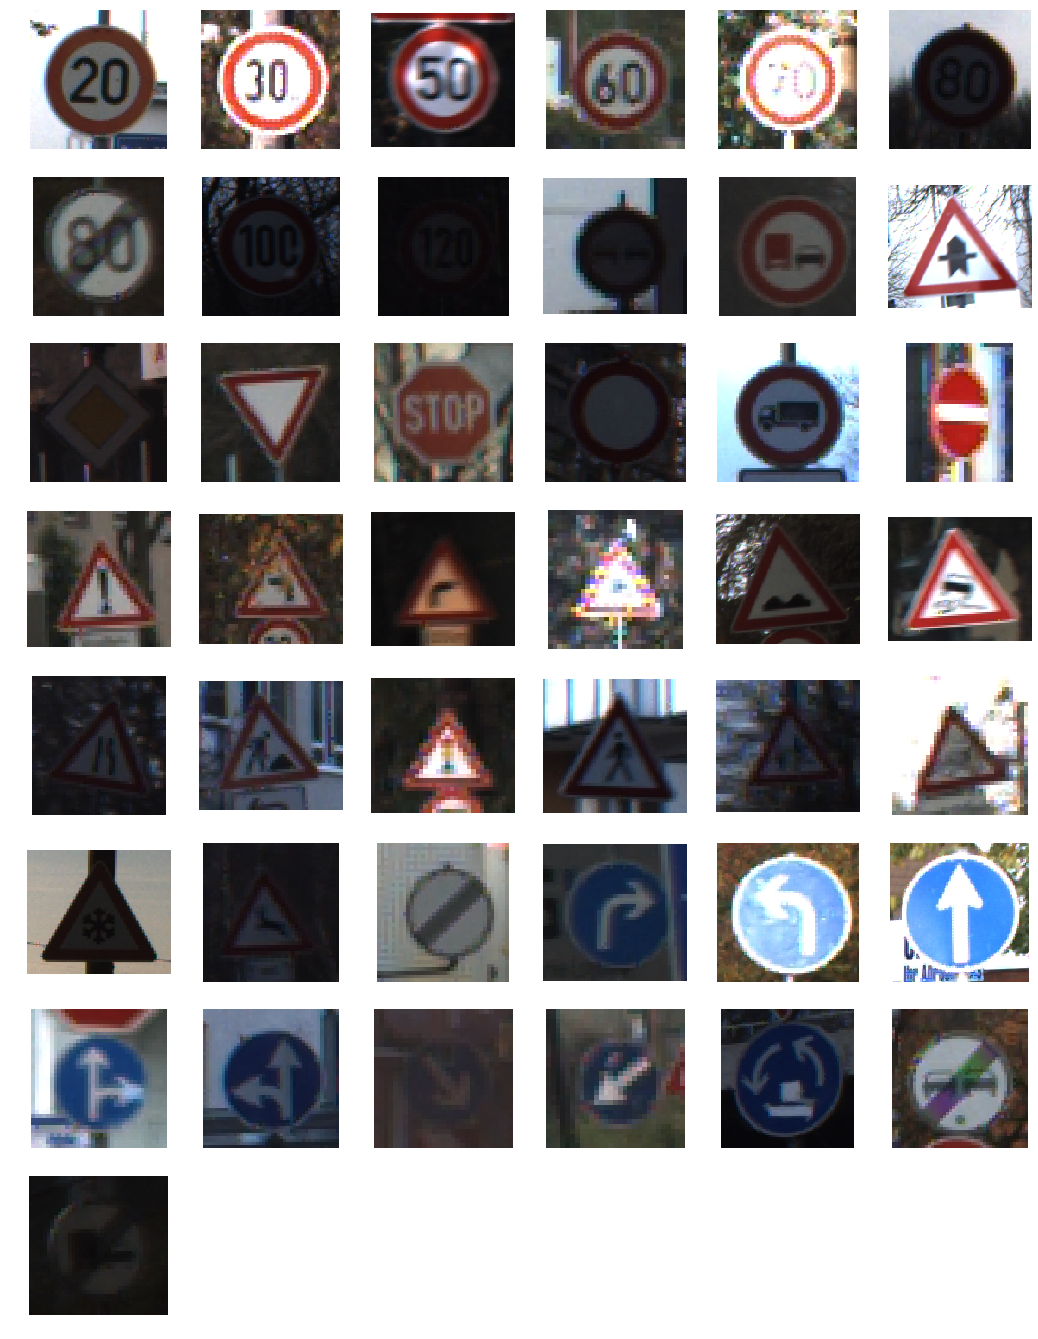

In [11]:
show_images(pic_offset)
pic_offset += 1

Загрузка и подготовка данных:

In [12]:
TARGET_SIZE = (40, 40) # изображения будут изменены до этого размера
BATCH_SIZE=300

In [13]:
paths = train_info['Path'].values
y_train = train_info['ClassId'].values

indices = np.arange(y_train.shape[0])
randgen = random.Random(62)
randgen.shuffle(indices)

paths = paths[indices]
y_train = y_train[indices]
y_train = to_categorical(y_train, 43)

data=[]

for i, f in enumerate(paths):
    print('\rLoading data {0:.1f}%...'.format((i / len(paths)) * 100), end = '\r')
    image = Image.open(os.path.join(from_input('train'), f.replace('Train/', '')))
    resized_image = image.resize(TARGET_SIZE)
    data.append(np.array(resized_image))

X_train = np.array(data).astype('float32') / 255.0

print('Data loaded.              ')

train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train,
                                    y_train,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    seed=17)

Data loaded.              


In [14]:
paths = test_info['Path'].values
y_test = test_info['ClassId'].values
y_test = to_categorical(y_test, 43)

data=[]

for i, f in enumerate(paths):
    print('\rLoading data {0:.1f}%...'.format((i / len(paths)) * 100), end = '\r')
    image = Image.open(os.path.join(from_input('test'), f.replace('Test/', '')))
    resized_image = image.resize(TARGET_SIZE)
    data.append(np.array(resized_image))

print('Data loaded.              ')

X_test = np.array(data).astype('float32') / 255.0 

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(X_test,
                                    y_test,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    seed=17)

Data loaded.              


Некоторые вспомогательные функции:

In [15]:
def plot(history):
    %matplotlib inline

    import matplotlib.image  as mpimg
    import matplotlib.pyplot as plt

    acc=history.history['acc']
    loss=history.history['loss']
    epochs=range(len(acc))

    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.title('Training accuracy')
    plt.xlabel('Epoch')
    plt.figure()

    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.xlabel('Epoch')
    plt.title('Training loss')

In [16]:
def show_layers(model):
    print('Name\tOutput shape\tActivation\tInitializer')
    for l in model.layers:
        print('{0}({1})\t{2}\t{3}\t{4}'
            .format(l.name,
              l.__class__.__name__,
              l.output_shape,
              l.activation.__name__ if hasattr(l, 'activation') else '<none>',
              l.kernel_initializer.__class__.__name__ if hasattr(l, 'kernel_initializer') else '<none>'))


def custom_summary(model):
    model.summary()
    show_layers(model)

In [17]:
VERBOSE=0

In [18]:
def train_model(model, kernel_initializer, optimizer, epochs):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    start_time = timer()
    history = model.fit_generator(train_generator,
                        epochs=epochs,
                        verbose=VERBOSE,
                        steps_per_epoch= round(X_train.shape[0] / BATCH_SIZE))
    end_time = timer()
    
    custom_summary(model)
    print('==============================')
    print('Initializer: ', kernel_initializer)
    print('Optimizer: ', optimizer.__class__.__name__)
    print('Learning rate: ', optimizer.get_config()['learning_rate'])
    print('Epochs: ', epochs)
    print('==============================')
    print('Trained in {0:.2f} minutes'.format((end_time - start_time) / 60))
    
    acc=history.history['acc'][-1]
    test_acc = model.evaluate_generator(test_generator)[1]
    
    print('Results at the end of training: acc={1:.02f}%, test_acc={2:.02f}%'
          .format(i, acc*100, test_acc*100))

    plot(history)

Тренируем сети:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 38, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 46208)             0         
_________________________________________________________________
dense (Dense)                (None, 43)                1986987   
Total params: 1,990,571
Trainable params: 1,990,571
Non-trainable params: 0
_________________________________________________________________
Name	Output shape	Activation	Initializer
conv2d(Conv2D)	(None, 38, 38, 128)	relu	GlorotUniform
max_pooling2d(MaxPooling2D)	(None, 19, 19, 128)	<none>	<none>
flatten(Flatten)	(None, 46208)	<none>	<none>
dense(Dense)	(None, 43)	softmax	GlorotUnif

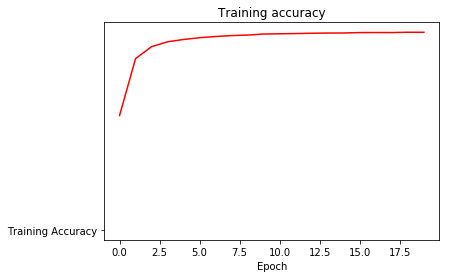

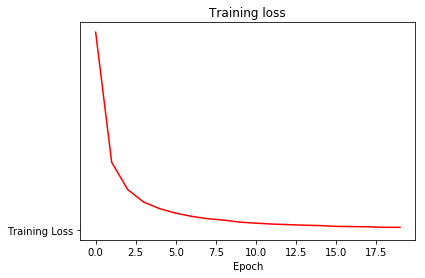

In [19]:
kernel_initializer='glorot_uniform'
optimizer=Adam(learning_rate=0.0005)
epochs=20

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Попробуем добавлять слои:

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 38, 128)       3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 43)                352299    
Total params: 503,467
Trainable params: 503,467
Non-trainable params: 0
________________________________________________

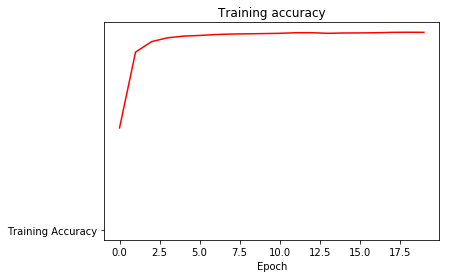

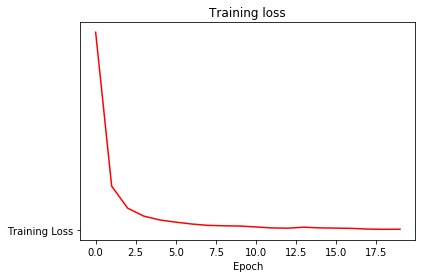

In [20]:
kernel_initializer='glorot_uniform'
optimizer=Adam(learning_rate=0.0005)
epochs=20

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 38, 38, 128)       3584      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 19, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 17, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 128)         147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

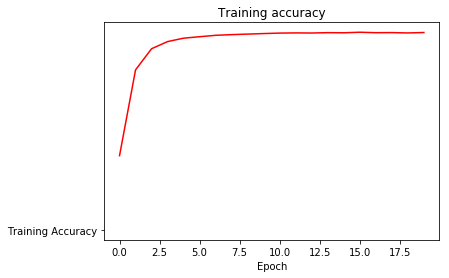

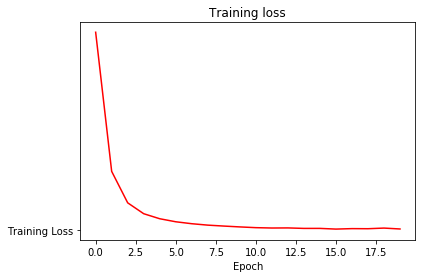

In [21]:
kernel_initializer='glorot_uniform'
optimizer=Adam(learning_rate=0.0005)
epochs=20

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Не стоит добавлять больше одинаковых слоёв. Попробуем изменять количество фильтров.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 38, 38, 256)       7168      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 19, 19, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 17, 17, 128)       295040    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 64)          73792     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)              

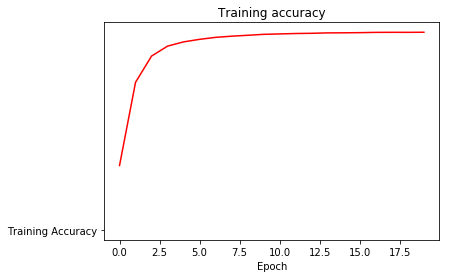

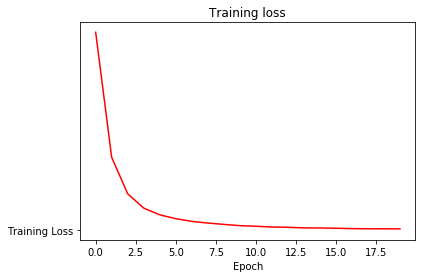

In [22]:
kernel_initializer='glorot_uniform'
optimizer=Adam(learning_rate=0.0005)
epochs=20

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Попробуем обратный подход, должен дать получше результаты.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 38, 38, 64)        1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 17, 17, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 256)         295168    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 256)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2304)             

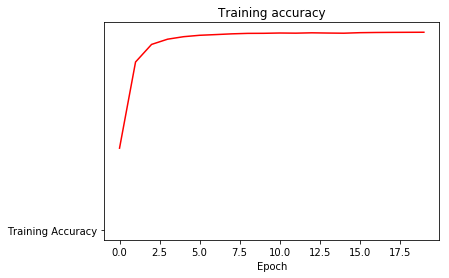

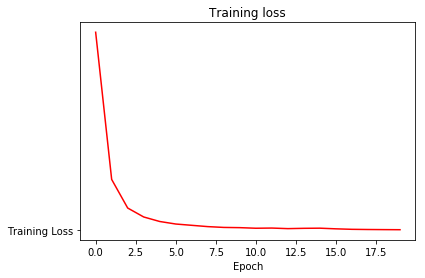

In [23]:
kernel_initializer='glorot_uniform'
optimizer=Adam(learning_rate=0.0005)
epochs=20

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Стало лучше. Попробуем уменьшить и увеличить количество фильтров.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 38, 38, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 6, 128)         73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)             

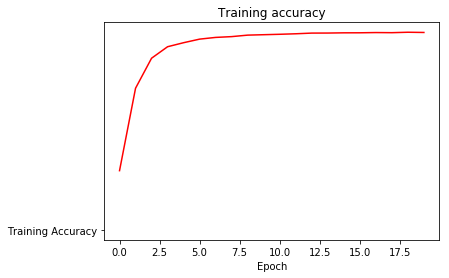

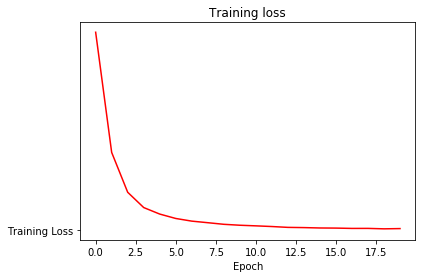

In [24]:
kernel_initializer='glorot_uniform'
optimizer=Adam(learning_rate=0.0005)
epochs=20

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 38, 38, 128)       3584      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 19, 19, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 17, 17, 256)       295168    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 6, 6, 512)         1180160   
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4608)             

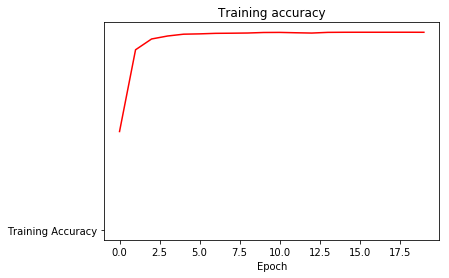

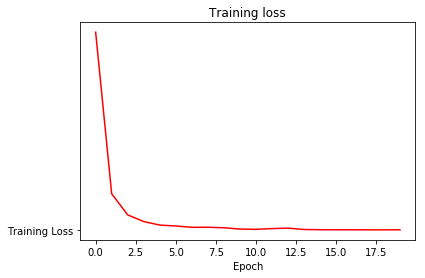

In [25]:
kernel_initializer='glorot_uniform'
optimizer=Adam(learning_rate=0.0005)
epochs=20

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 38, 38, 256)       7168      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 19, 19, 256)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 17, 17, 512)       1180160   
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 6, 6, 1024)        4719616   
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 3, 3, 1024)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9216)             

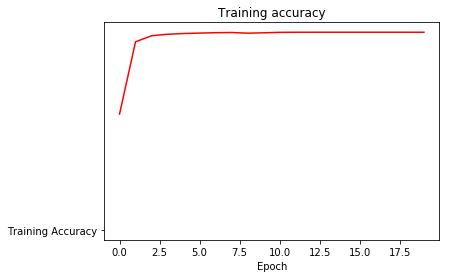

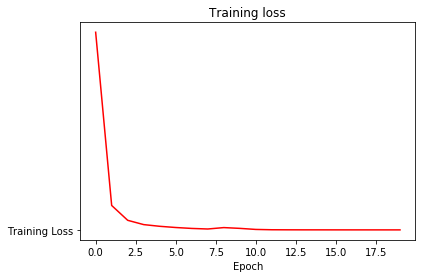

In [26]:
kernel_initializer='glorot_uniform'
optimizer=Adam(learning_rate=0.0005)
epochs=20

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Попробуем увеличить размер ядра в первом свёрточном слое, так как тут размер карты признаков достаточно большой.

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 36, 36, 256)       19456     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 18, 18, 256)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 512)       1180160   
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 6, 6, 1024)        4719616   
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 3, 3, 1024)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 9216)             

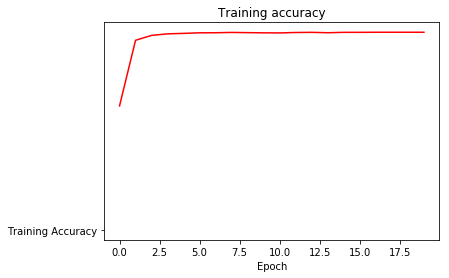

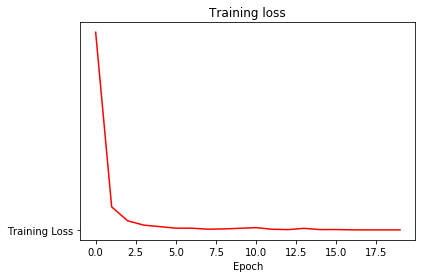

In [27]:
kernel_initializer='glorot_uniform'
optimizer=Adam(learning_rate=0.0005)
epochs=20

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (5, 5), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 34, 34, 256)       37888     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 15, 15, 512)       1180160   
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 5, 5, 1024)        4719616   
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 2, 2, 1024)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 4096)             

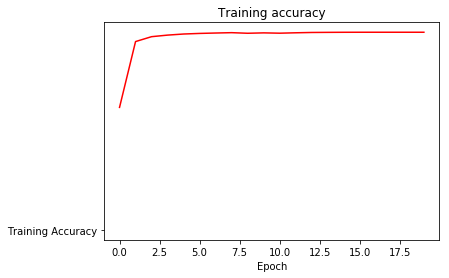

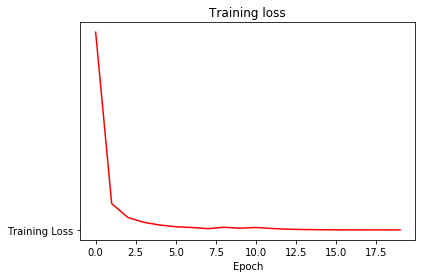

In [28]:
kernel_initializer='glorot_uniform'
optimizer=Adam(learning_rate=0.0005)
epochs=20

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (7, 7), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Попробуем использовать тангенс гиперболический, но в первом слое оставим relu что бороться с исчезающим градиентом.

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 34, 34, 256)       37888     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 15, 15, 512)       1180160   
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 5, 5, 1024)        4719616   
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 2, 2, 1024)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4096)            

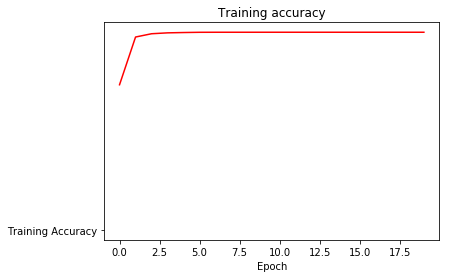

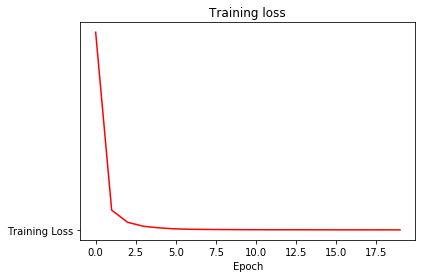

In [29]:
kernel_initializer='glorot_uniform'
optimizer=Adam(learning_rate=0.0005)
epochs=20

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (7, 7), activation='relu', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='tanh', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(1024, (3, 3), activation='tanh', input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Результаты очевидно значительно хуже по сравнению с тренировочнoй выборкой, но тем не менее хорошие. Причин может быть много, разница между тестовыми и тренировочными данными может быть большой. Может стоит добавлять регуляризацию, Dropout, а также искусственно изменять и добавлять данные в тренировочную выборку (augmentation).